## Importing the input vectors

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run the data preparation notebook
X_analog_feb = pd.DataFrame(np.load("npy_files/X_analog_feb.npy"))
X_analog_may_june = pd.DataFrame(np.load("npy_files/X_analog_may_june.npy"))


In [25]:
X_analog_may_june.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.014776,0.139931,0.396183,0.391436,0.342122,0.226712,-0.021780,0.160426,-0.246660,-0.742034,0.172732,-0.822266,-0.464341,-0.432601,-0.047292,0.012358,0.0
1,-0.094405,0.196174,0.399288,0.406951,0.322616,0.203375,-0.024953,0.377741,0.638057,-0.096832,0.375188,-0.821126,-0.464341,-0.432601,-0.044720,0.014667,0.0
2,0.045894,0.152430,0.399288,0.410830,0.332369,0.203375,-0.034472,0.479154,0.427705,-0.162819,0.260562,-0.822266,-0.464341,-0.432601,-0.047292,0.014457,0.0
3,0.315116,0.661743,0.421024,0.441858,0.361629,0.232546,-0.021780,0.526239,0.724673,-0.155487,0.250141,-0.821126,-0.463069,-0.431200,-0.042149,0.014877,0.0
4,0.095188,0.486764,0.417919,0.430223,0.356752,0.232546,-0.018607,0.533483,0.588562,-0.144489,0.300755,-0.821126,-0.463069,-0.431200,-0.044720,0.014457,0.0


#### Divide into train data and test data

In [26]:
raw_data_may_june = X_analog_may_june.values

In [27]:
# The last element contains the labels
labels = raw_data_may_june[:, -1]

# The other data points are the data
data = raw_data_may_june[:, 0:-1]

train_data_may_june, test_data_may_june, train_labels_may_june, test_labels_may_june = train_test_split(
    data, labels, test_size=0.2, shuffle=True, random_state=21
)

train_data_may_june = tf.cast(train_data_may_june, tf.float32)
test_data_may_june = tf.cast(test_data_may_june, tf.float32)

train_labels_may_june = train_labels_may_june.astype(bool)
test_labels_may_june = test_labels_may_june.astype(bool)

normal_train_data_may_june = train_data_may_june[~train_labels_may_june]
normal_test_data_may_june = test_data_may_june[~test_labels_may_june]

anomalous_train_data_may_june = train_data_may_june[train_labels_may_june]
anomalous_test_data_may_june = test_data_may_june[test_labels_may_june]

## Autoencoder

Epoch 1/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 75.9827 - val_loss: 23.7094
Epoch 2/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.9686 - val_loss: 13.8626
Epoch 3/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.0840 - val_loss: 10.8959
Epoch 4/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8374 - val_loss: 9.3580
Epoch 5/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2991 - val_loss: 8.1502
Epoch 6/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0007 - val_loss: 7.2569
Epoch 7/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5445 - val_loss: 6.6227
Epoch 8/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0999 - val_loss: 6.2760
Epoch 9/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8278 - val_loss: 5.9565
Epoch 10/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5454 - val_loss: 5.5968
Epoch 11/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2604 - val_loss: 5.4613
Epoch 12/100
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

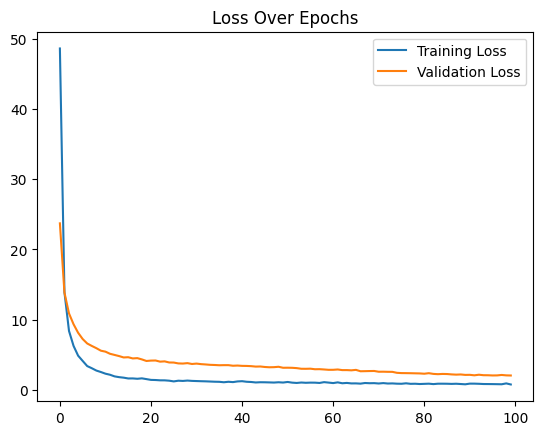

In [41]:
# Define input dimension
input_dim = normal_train_data_may_june.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='relu', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='relu', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='relu', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='relu', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='relu', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='relu', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='relu', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),#learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=normal_train_data_may_june,  # Input and target are the same for autoencoders
    y=normal_train_data_may_june,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(normal_test_data_may_june, normal_test_data_may_june)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Threshold:  0.61864054
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


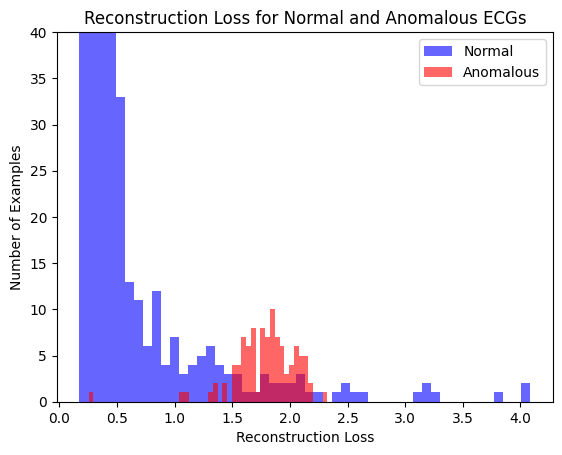

Accuracy = 97.80701754385966%
Precision = 99.82425307557118%
Recall = 97.59450171821305%
F1 Score = 98.69678540399653%


In [42]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(normal_train_data_may_june)
train_loss = tf.keras.losses.mae(reconstructions_normal, normal_train_data_may_june)

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
threshold=1 ########################################################################################################################################################

reconstructions_anomalous = autoencoder.predict(anomalous_test_data_may_june)
test_loss = tf.keras.losses.mae(reconstructions_anomalous, anomalous_test_data_may_june)

# Plot both losses on the same histogram
plt.hist(train_loss, bins=50, alpha=0.6, color='blue', label='Normal')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous ECGs")
plt.ylim((0, 40))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions)))

preds = predict(autoencoder, test_data_may_june, threshold)
print_stats(preds, test_labels_may_june)

In [43]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(~test_labels_may_june, preds)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[101   1]
 [ 14 568]]


### Training and validating with February. Evaluating on May/June

### ____________________________________________________________________________________________________________________________________________________________

In [45]:
raw_data_feb = X_analog_feb.values

In [49]:
# The other data points are the data
data = raw_data_feb

train_data_feb, test_data_feb = train_test_split(
    data, test_size=0.2, shuffle=True, random_state=21
)

train_data_feb = tf.cast(train_data_feb, tf.float32)
test_data_feb = tf.cast(test_data_feb, tf.float32)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 143.3393 - val_loss: 85.8980
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 70.8768 - val_loss: 64.3059
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55.3434 - val_loss: 51.3084
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 41.3157 - val_loss: 40.9866
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33.7319 - val_loss: 33.1242
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.7231 - val_loss: 27.1060
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.5261 - val_loss: 22.2783
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.5408 - val_loss: 18.6341
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14.2668 - val_loss: 15.7435
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.5137 - val_loss: 13.6090
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.1867 - val_loss: 11.7433
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━

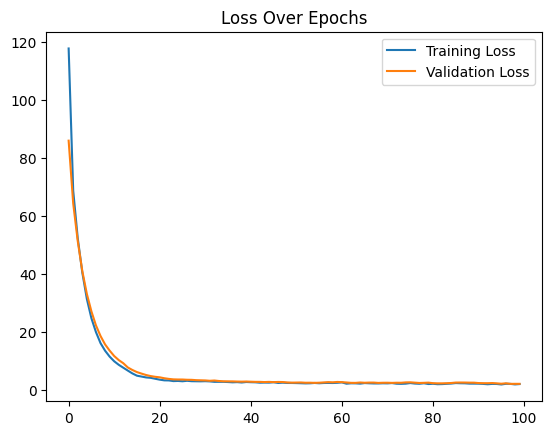

In [50]:
# Define input dimension
input_dim = train_data_feb.shape[1]

# Encoder: Three layers plus bottleneck
input_layer = Input(shape=(input_dim,), name='input')
encoded = Dense(128, activation='relu', name='encoder_layer1')(input_layer)
encoded = Dense(64, activation='relu', name='encoder_layer2')(encoded)
encoded = Dense(32, activation='relu', name='encoder_layer3')(encoded)
bottleneck = Dense(12, activation='relu', name='bottleneck')(encoded)

# Decoder: Three layers mirroring the encoder
decoded = Dense(32, activation='relu', name='decoder_layer1')(bottleneck)
decoded = Dense(64, activation='relu', name='decoder_layer2')(decoded)
decoded = Dense(128, activation='relu', name='decoder_layer3')(decoded)
output_layer = Dense(input_dim, activation='sigmoid', name='output')(decoded)


autoencoder = Model(input_layer, output_layer)

# Custom loss function class
class SparseAutoencoderLoss(tf.keras.losses.Loss):
    def __init__(self, model, lambda_reg=1e-3, beta=1e-5, sparsity_target=0.05):
        super(SparseAutoencoderLoss, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg
        self.beta = beta
        self.sparsity_target = sparsity_target

    def get_layer_activations(self, data):
        layer_outputs = [layer.output for layer in self.model.layers if 'encoder' in layer.name or 'decoder' in layer.name or 'bottleneck' in layer.name]
        activation_model = Model(inputs=self.model.input, outputs=layer_outputs)
        activations = activation_model(data)
        return activations

    def call(self, y_true, y_pred):
        # Mean Squared Error
        mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))

        # Frobenius norm
        frobenius_loss = 0
        for layer in self.model.layers:
            if hasattr(layer, 'kernel'):
                frobenius_loss += tf.reduce_sum(tf.square(layer.kernel))
        frobenius_loss *= self.lambda_reg

        # Kullback-Leibler divergence
        activations = self.get_layer_activations(y_true)
        kl_divergence = 0
        for activation in activations:
            rho_hat = tf.reduce_mean(activation, axis=0)  # Average activation per neuron
            kl_divergence += tf.reduce_sum( #reduce_sum takes the entire rho_hat vector and sums it up in the formula
            0.01 * tf.math.log(0.01 / (rho_hat + 1e-7)) +
            (1 - 0.01) * tf.math.log((1 - 0.01) / (1 - rho_hat + 1e-7))
            )
        kl_loss = self.beta * kl_divergence

        # Total loss
        return mse_loss + frobenius_loss + kl_loss

# Compile the model with the custom loss
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(),#learning_rate=0.01),
    loss=SparseAutoencoderLoss(model=autoencoder, lambda_reg=1e-5, beta=5, sparsity_target=0.01)
)

# Train the model
history = autoencoder.fit(
    x=train_data_feb,  # Input and target are the same for autoencoders
    y=train_data_feb,  # Input and target are the same for autoencoders
    epochs=100, 
    batch_size=30, 
    validation_data=(test_data_feb, test_data_feb)
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Threshold:  0.9869408
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


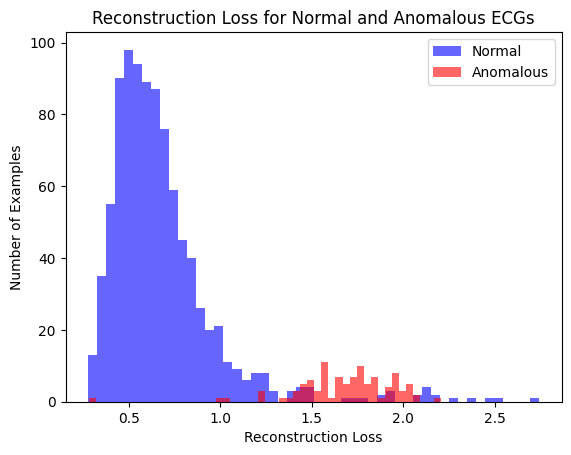

Accuracy = 97.80701754385966%
Precision = 98.96373056994818%
Recall = 98.4536082474227%
F1 Score = 98.70801033591732%


In [54]:
# Classify an ECG as anomalous if the reconstruction error is greater than one standard deviation
reconstructions_normal = autoencoder.predict(train_data_feb)
train_loss = tf.keras.losses.mae(reconstructions_normal, train_data_feb)

threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)
threshold=1.3 ########################################################################################################################################################

reconstructions_anomalous = autoencoder.predict(anomalous_test_data_may_june)
test_loss = tf.keras.losses.mae(reconstructions_anomalous, anomalous_test_data_may_june)

# Plot both losses on the same histogram
plt.hist(train_loss, bins=50, alpha=0.6, color='blue', label='Normal')
plt.hist(test_loss, bins=50, alpha=0.6, color='red', label='Anomalous')

plt.xlabel("Reconstruction Loss")
plt.ylabel("Number of Examples")
plt.legend(loc='upper right')
plt.title("Reconstruction Loss for Normal and Anomalous ECGs")
#plt.ylim((0, 40))
plt.show()


# Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    print("Accuracy = {}%".format(100*accuracy_score(~labels, predictions)))
    print("Precision = {}%".format(100*precision_score(~labels, predictions)))
    print("Recall = {}%".format(100*recall_score(~labels, predictions)))
    print("F1 Score = {}%".format(100*f1_score(~labels, predictions)))

preds = predict(autoencoder, test_data_may_june, threshold)
print_stats(preds, test_labels_may_june)